# Stochastic Gradient Descent with Backpropagation

In this notebook, I explore the powerful combination of Stochastic Gradient Descent (SGD) and Backpropagation, two foundational techniques that make training deep learning models effective and scalable. Backpropagation is an algorithm for efficiently computing gradients of a model’s parameters with respect to a loss function, enabling the model to learn from its errors. Stochastic Gradient Descent is an optimization method that updates these parameters incrementally using small, randomly selected batches of data, rather than the entire dataset. Together, they form the backbone of modern neural network training: backpropagation provides the direction for parameter updates, and SGD ensures those updates are computationally efficient and less prone to getting stuck in poor local minima. This synergy is what allows deep networks to learn complex patterns in large datasets.

This notebook leverages [torch](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html) and it assumes a basic working knowledge of the software.

## Let's figure out clothes!

We'll be using the Fashion-MNIST dataset to demonstrate how Stochastic Gradient Descent (SGD) and Backpropagation work together to train a neural network to recognize clothing in images!

Fashion-MNIST is a collection of 70,000 grayscale images of clothing items, divided into 10 categories such as t-shirts, sneakers, and coats. Each image is 28x28 pixels and labeled with its corresponding clothing type. PyTorch provides built-in support for downloading and loading this dataset through the torchvision library. When we run the loading code, the dataset will be:

* Automatically downloaded from the official source if it's not already on your machine.
* Stored in a ./data directory relative to your notebook.
* Transformed into tensors, which are the basic data structures used in PyTorch.
* Normalized, so that pixel values are scaled in a way that helps the model learn more effectively.
* We'll split the dataset into training and test sets
* Use PyTorch's DataLoader to efficiently iterate over batches during training

This setup mimics the way data is handled in real-world deep learning projects and makes it easy to observe how our model improves with each batch.

In [1]:
import torch
from torchvision import datasets, transforms
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
import numpy as np
import os

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}.")

transform = transforms.Compose([
    # Transforms an image into a PyTorch sensor
    # Each image is comprised of (Height, Width, Channels), PyTorch transforms this to (Channels, Height, Width).
    #
    # Height of the image, width of the image are self explanatory.
    #
    # Channels of an image can vary based on image type, for example:
    # 1 → Grayscale
    # 3 → RGB (Red, Green, Blue)
    # 4 → RGBA (includes alpha/transparency)
    #
    # It also normalizes pixel values based on channel into a common format. For grey scale: [0, 255] -> [0, 1], 128/255 => 0.502
    transforms.ToTensor(),
    # Normalizes every pixel between a range of [-1, 1] from [0, 1] above
    transforms.Normalize((0.5,), (0.5,)) 
])

train_dataset = FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

/home/mtrottie/code/RecommenderSystems/.env/lib/python3.12/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Running on cpu.


100.0%
100.0%
100.0%
100.0%


## Train vs Test Loaders

The `train_loader` provides batches of images and their labels from the training set. These are used to teach the model: it makes predictions on each image, compares them to the correct labels (which represent the clothing item types), and updates its internal weights using backpropagation and stochastic gradient descent. The goal is for the model's output to increasingly match the true label — for example, predicting "Sneaker" when shown an image labeled as such.

The `test_loader` provides a separate set of images and labels that the model hasn't seen during training. It’s used to evaluate how well the model generalizes to new data. No learning happens here; we simply compare the model’s predictions to the true labels to measure accuracy.

## Labels and Visualizing the data set

To get a sense of the dataset, we’ll display a small grid of randomly selected training images. Each image will be shown in grayscale alongside its corresponding clothing label, such as “T-Shirt” or “Sneaker.” This helps visualize the kinds of items the model will learn to classify and gives an intuitive feel for the variety and style of the Fashion-MNIST data.

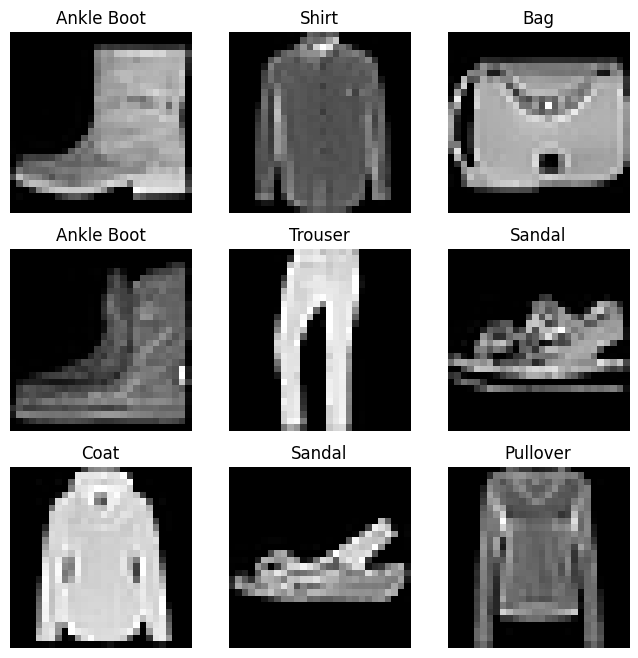

In [2]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
classes = ('T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

figure = plt.figure(figsize=(8, 8))

cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

# Let's build a neural network!

Convolutional Neural Networks (CNNs) have revolutionized the field of computer vision. They are specifically designed to recognize visual patterns directly from pixel images with minimal preprocessing. CNNs are hierarchical models where neurons in one layer connect to neurons in the next layer in a limited fashion, somewhat like the receptive field in human vision.

A typical CNN architecture consists of:

1. Convolutional Layers: Apply convolution operation on the input layer to detect features.
1. Activation Layers: Introduce non-linearity to the model (typically ReLU).
1. Pooling Layers: Perform down-sampling operations to reduce dimensionality.
1. Fully Connected Layers: After several convolutional and pooling layers, the high-level reasoning in the neural network happens via fully connected layers.

Here is an example (shamelessly stolen from a Medium article) that generally represents our architecutre. Take a look at the picture and notice how our BasicCNN differs.

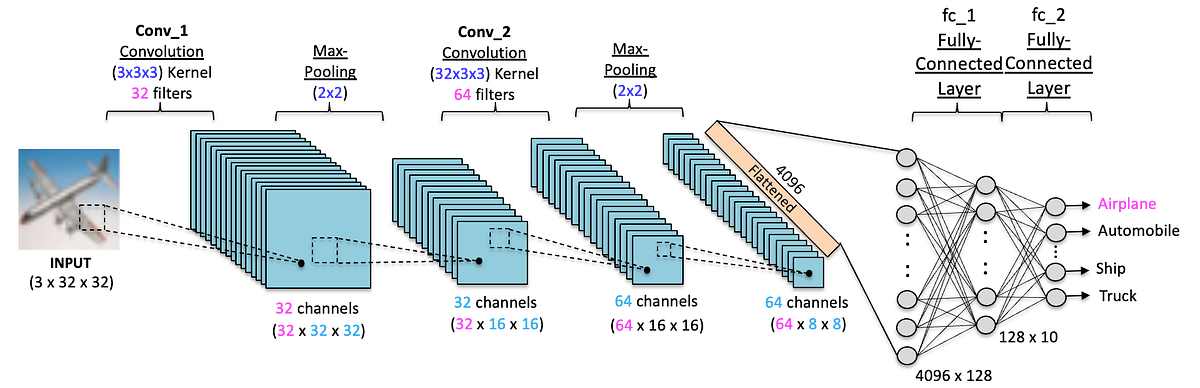

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        
        # First convolutional layer:
        # - Input channels: 1 (grayscale image)
        # - Output channels: 32 (learned filters)
        # - Kernel size: 3x3
        self.conv1 = nn.Conv2d(1, 32, 3)  # Output: [batch_size, 32, 26, 26]
        
        # Second convolutional layer:
        # - Input channels: 32 (from previous layer)
        # - Output channels: 64
        # - Kernel size: 3x3
        self.conv2 = nn.Conv2d(32, 64, 3) # Output: [batch_size, 64, 11, 11]

        # First fully connected layer:
        # - Input size: 64 channels * 5 * 5 spatial locations (after conv + pooling)
        # - Output size: 128 neurons
        self.fc1 = nn.Linear(64 * 5 * 5, 128)

        # Final fully connected layer:
        # - Input size: 128 (from previous layer)
        # - Output size: 10 (one for each class of clothing)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Input shape: [batch_size, 1, 28, 28]
        # Apply first conv layer + ReLU activation
        x = F.relu(self.conv1(x))        # Output: [batch_size, 32, 26, 26]

        # Apply 2x2 max pooling to reduce spatial size
        x = F.max_pool2d(x, 2)           # Output: [batch_size, 32, 13, 13]

        # Apply second conv layer + ReLU
        x = F.relu(self.conv2(x))        # Output: [batch_size, 64, 11, 11]

        # Apply another 2x2 max pooling
        x = F.max_pool2d(x, 2)           # Output: [batch_size, 64, 5, 5]

        # Flatten the tensor for the fully connected layers
        x = x.view(-1, 64 * 5 * 5)       # Output: [batch_size, 1600]

        # Apply first fully connected layer + ReLU
        x = F.relu(self.fc1(x))          # Output: [batch_size, 128]

        # Apply final layer to get class scores
        x = self.fc2(x)                  # Output: [batch_size, 10]

        # Apply log-softmax to get log-probabilities
        return F.log_softmax(x, dim=1)   # Output: [batch_size, 10]

print("""Input Layer (1x28x28 image)
        █████████████████
        █               █
        █   28x28 Grid  █
        █               █
        █████████████████
                 │
                 ▼
Convolutional Layer 1 (32 filters, 3x3 kernel)
        ┌───────────┐
        │ ● ● ● ... │  ← 32 feature maps
        └───────────┘
                 │
                 ▼
Convolutional Layer 2 (64 filters, 3x3 kernel)
        ┌────────────┐
        │ ● ● ● ...  │  ← 64 feature maps
        └────────────┘
                 │
        MaxPool2D (twice)
                 │
                 ▼
Flatten (64 × 5 × 5 → 1600 neurons)
        ● ● ● ● ● ● ● ● ● ● ...
                 │
                 ▼
Fully Connected Layer 1 (128 neurons)
        ● ● ● ● ● ● ● ● ● ● ...
                 │
                 ▼
Fully Connected Layer 2 (10 neurons)
        ● ● ● ● ● ● ● ● ● ●
                 │
                 ▼
Output: class scores (e.g., T-shirt, Sneaker, etc.)
""")

Input Layer (1x28x28 image)
        █████████████████
        █               █
        █   28x28 Grid  █
        █               █
        █████████████████
                 │
                 ▼
Convolutional Layer 1 (32 filters, 3x3 kernel)
        ┌───────────┐
        │ ● ● ● ... │  ← 32 feature maps
        └───────────┘
                 │
                 ▼
Convolutional Layer 2 (64 filters, 3x3 kernel)
        ┌────────────┐
        │ ● ● ● ...  │  ← 64 feature maps
        └────────────┘
                 │
        MaxPool2D (twice)
                 │
                 ▼
Flatten (64 × 5 × 5 → 1600 neurons)
        ● ● ● ● ● ● ● ● ● ● ...
                 │
                 ▼
Fully Connected Layer 1 (128 neurons)
        ● ● ● ● ● ● ● ● ● ● ...
                 │
                 ▼
Fully Connected Layer 2 (10 neurons)
        ● ● ● ● ● ● ● ● ● ●
                 │
                 ▼
Output: class scores (e.g., T-shirt, Sneaker, etc.)



MaxPool2D: 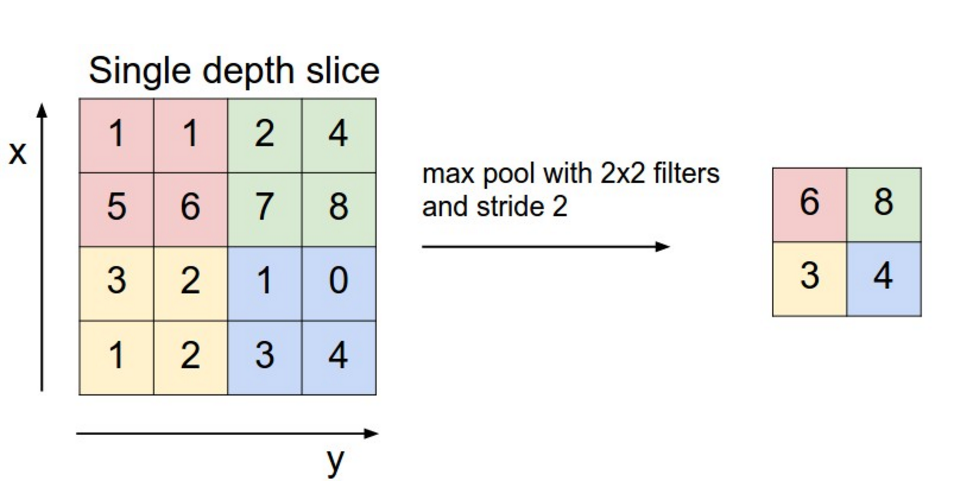


In [4]:
# Create the model
model = BasicCNN()

# lr = Learning Rate
# Adam = combines the advantages of two other extensions of SGD, AdaGrad and RMSProp. These adjust the learning rate of each weight based on historial graident information.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Cross Entropy Loss is used for multi-class classification. It quanitifes the difference between the predicted probability distribution and the actual distribution.
criterion = nn.CrossEntropyLoss()

## Training the Model

In [5]:
# Number of complete passes through the dataset
num_epochs = 10

# Start the training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()

    correct = 0
    total = 0
    
    # Iterate over each batch of the training data
    for images, labels in train_loader:
        # Move the images and labels to the computational device (CPU or GPU)
        images, labels = images.to(device), labels.to(device)
        
        # Clear the gradients from the previous iteration
        optimizer.zero_grad()
        
        # Forward pass: Pass the images through the model to get the predicted outputs
        outputs = model(images)
        
        # Compute the loss between the predicted outputs and the true labels
        loss = criterion(outputs, labels)
        
        # Backward pass: Compute the gradient of the loss w.r.t. model parameters
        loss.backward()
        
        # Update the model parameters
        optimizer.step()

        # Compute predictions
        _, predicted = torch.max(outputs.data, 1)

        # Update total and correct
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Accuracy: {accuracy:.2f}%")

Epoch [1/10], Training Accuracy: 82.88%
Epoch [2/10], Training Accuracy: 88.52%
Epoch [3/10], Training Accuracy: 90.29%
Epoch [4/10], Training Accuracy: 91.34%
Epoch [5/10], Training Accuracy: 92.37%
Epoch [6/10], Training Accuracy: 93.24%
Epoch [7/10], Training Accuracy: 93.90%
Epoch [8/10], Training Accuracy: 94.55%
Epoch [9/10], Training Accuracy: 95.24%
Epoch [10/10], Training Accuracy: 95.87%


## Evaluation

Once the model is trained, it's crucial to evaluate its performance on unseen data. We'll generate predictions for the test set, compute the overall accuracy and examine the model's performacne in detail using a foncusion matrix and classification report. These tools will provide insights into specific areas wehre the model excels or might need improvement.


              precision    recall  f1-score   support

     T-shirt       0.84      0.88      0.86      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.79      0.92      0.85      1000
       Dress       0.90      0.93      0.92      1000
        Coat       0.90      0.82      0.86      1000
      Sandal       0.98      0.99      0.99      1000
       Shirt       0.79      0.68      0.73      1000
     Sneaker       0.97      0.96      0.97      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.97      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



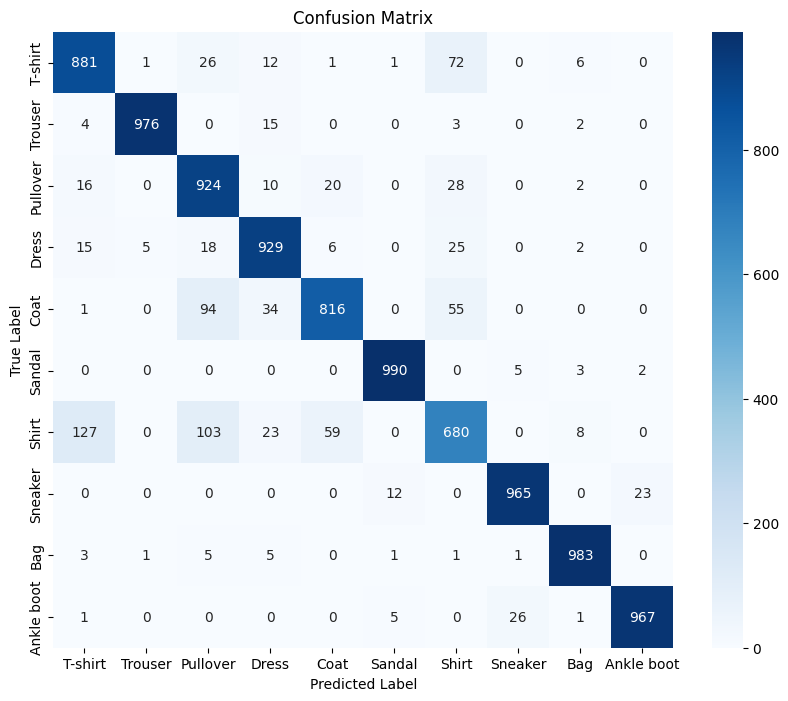

In [6]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Set the model to evaluation mode. This is important as certain layers like dropout behave differently during training and evaluation.
model.eval()

# Lists to store all predictions and true labels
all_preds = []
all_labels = []

# We don't want to compute gradients during evaluation, hence wrap the code inside torch.no_grad()
with torch.no_grad():
    # Iterate over all batches in the test loader
    for images, labels in test_loader:
        # Transfer images and labels to the computational device (either CPU or GPU)
        images, labels = images.to(device), labels.to(device)
        
        # Pass the images through the model to get predictions
        outputs = model(images)
        
        # Get the class with the maximum probability as the predicted class
        _, predicted = torch.max(outputs, 1)
        
        # Extend the all_preds list with predictions from this batch
        all_preds.extend(predicted.cpu().numpy())
        
        # Extend the all_labels list with true labels from this batch
        all_labels.extend(labels.cpu().numpy())

# Print a classification report which provides an overview of the model's performance for each class
print(classification_report(all_labels, all_preds, target_names=classes))

# Compute the confusion matrix using true labels and predictions
cm = confusion_matrix(all_labels, all_preds)

# Visualize the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')  # x-axis label
plt.ylabel('True Label')       # y-axis label
plt.title('Confusion Matrix')  # Title of the plot
plt.show()                     # Display the plot

In [7]:
import pandas as pd

# Convert to flat table
flat_cm = []

for true_idx, row in enumerate(cm):
    for pred_idx, count in enumerate(row):
        if count > 0:
            flat_cm.append({
                "True Label": classes[true_idx],
                "Predicted Label": classes[pred_idx],
                "Count": count
            })

# Create DataFrame
df = pd.DataFrame(flat_cm)

# Sort by True Label and descending count
df = df.sort_values(["True Label", "Count"], ascending=[True, False])

# Display table
print("Tabulated Confusion Matrix vs matrix view")
print(df.to_string(index=False))

Tabulated Confusion Matrix vs matrix view
True Label Predicted Label  Count
Ankle boot      Ankle boot    967
Ankle boot         Sneaker     26
Ankle boot          Sandal      5
Ankle boot         T-shirt      1
Ankle boot             Bag      1
       Bag             Bag    983
       Bag        Pullover      5
       Bag           Dress      5
       Bag         T-shirt      3
       Bag         Trouser      1
       Bag          Sandal      1
       Bag           Shirt      1
       Bag         Sneaker      1
      Coat            Coat    816
      Coat        Pullover     94
      Coat           Shirt     55
      Coat           Dress     34
      Coat         T-shirt      1
     Dress           Dress    929
     Dress           Shirt     25
     Dress        Pullover     18
     Dress         T-shirt     15
     Dress            Coat      6
     Dress         Trouser      5
     Dress             Bag      2
  Pullover        Pullover    924
  Pullover           Shirt     28
  Pull